# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib notebook
%pylab

from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

<Table length=14588>
       time             flux             error       quarter
     float64          float64           float64       int64 
----------------- ---------------- ----------------- -------
539.4710179205795 5221.16455078125 4.891251087188721       6
539.4914521464307 5216.07958984375 4.892819404602051       6
539.5118864718097    5225.43359375 4.891888618469238       6
539.5323205971945   5233.111328125 4.892074108123779       6
539.5527548221144 5221.17333984375 4.891964435577393       6
 539.573189147035 5220.09521484375 4.891523361206055       6
539.5936232714812 5222.14208984375 4.893854141235352       6
              ...              ...               ...     ...
905.8044143491425 5862.43798828125 4.119598388671875       9
 905.824848745775 5863.95458984375 4.118742942810059       9
 905.845282941933   5870.349609375 4.119640827178955       9
 905.865717337867 5867.27099609375 4.119102478027344       9
905.8861516335674 5868.67822265625 4.119019031524658       9
905.9065858290269   5864.173828125 4.119871616363525       9
905.9270202242624 5861.61572265625 4.119407653808594       9

<IPython.core.display.Javascript object>


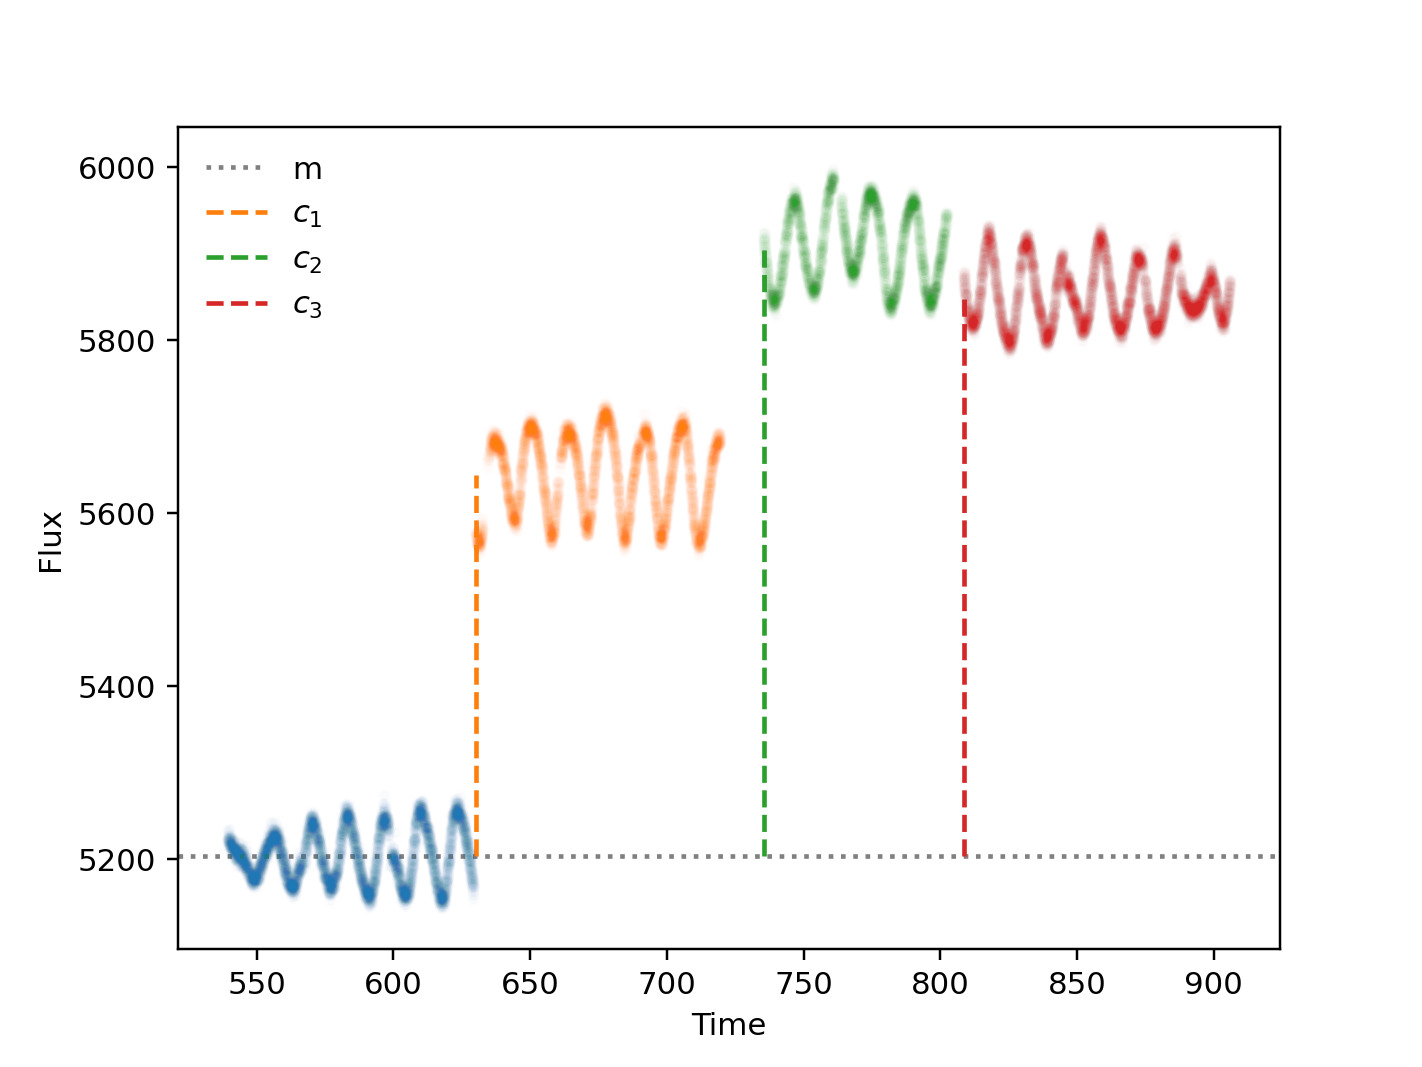

In [3]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [4]:
import george
from george import kernels

def kernel(A, gamma,logP, lam):
    return A*kernels.ExpSine2Kernel(gamma=gamma, log_period=logP)*kernels.ExpSquaredKernel(metric=lam)

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

In [5]:
# To define the cycles, we'll figure out the start time of each cycle, 
# which really defines the end time of the constant value for the previous cycle

transition_times = {key: tab[ind]['time'].min() for key, ind in cycle_map.items()}
print(transition_times)

{6: 539.4710179205795, 7: 630.1958363732629, 8: 735.40366757843, 9: 808.5360293126505}


In [6]:
from george.modeling import Model
class kepler_mean_model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    def get_value(self, t):
        
        t = t.flatten()
        # the baseline model is the mean m
        mean_model = np.repeat(self.m, len(t))
        
        # each cycle after 6 has it's own offset
        # you could do this with a single dictionary/list comprehension 
        ind = (t >= transition_times[7]) & (t < transition_times[8])
        mean_model[ind] += self.c1
        ind = (t >= transition_times[8]) & (t < transition_times[9])
        mean_model[ind] += self.c2
        ind = t >= transition_times[9]
        mean_model[ind] += self.c3
        
        return mean_model       

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

In [7]:
# First we'll do initial guesses:

# means and offsets are easy
m = means[0]
c1, c2, c3 = means[1:] - m

# just use the stddev for the first cycle to get some scale for the amplitude
A = tab['flux'][cycle_map[6]].std() 

# gamma is modulating the periodic variation - we'll just set it to 1.
gamma= 1.

# squiggles are roughly every 15 days from the plot
logP = np.log(15.)

# long-period variations are on the scale of the Kepler cycles - from cycle 8/9, this is maybe 150 days
lam  = 150

p0 = [m, c1, c2, c3, A, gamma, logP, lam]

<IPython.core.display.Javascript object>


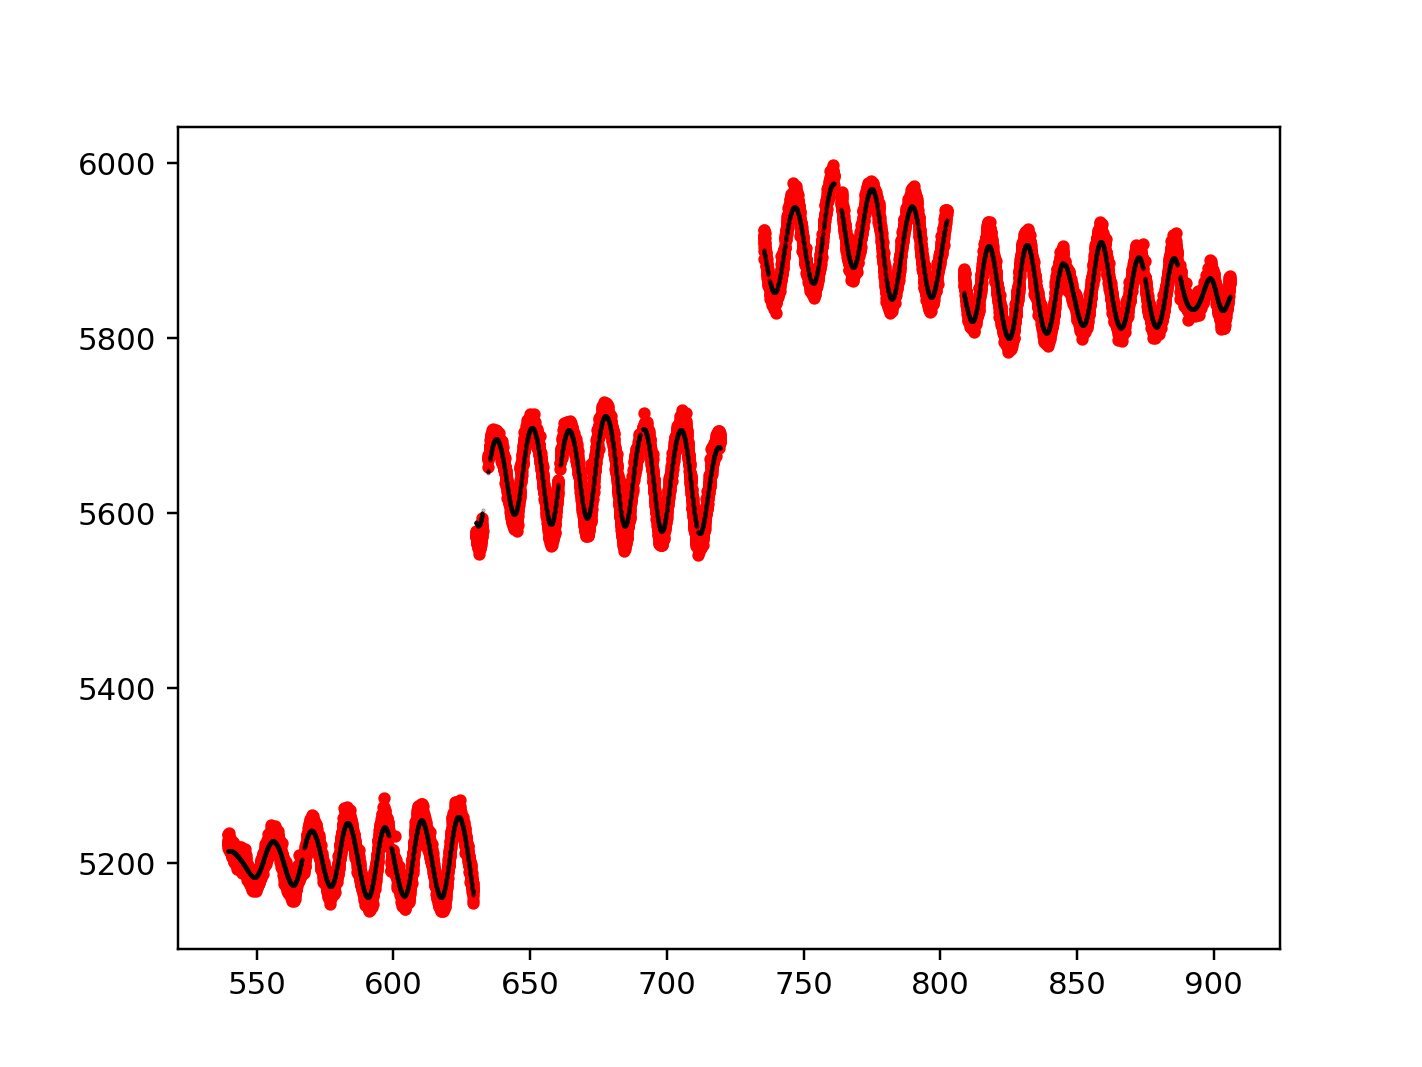

In [8]:
everyn = 30
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
t = tab['time'][::everyn]
y = tab['flux'][::everyn]
yerr = tab['error'][::everyn]

model = george.GP(mean=kepler_mean_model(m, c1, c2, c3), kernel=kernel(A, gamma, logP, lam))
model.compute(t, yerr)
pred = model.predict(y, tab['time'], return_cov=False)

ax2.plot(tab['time'], tab['flux'], 'r.')
ax2.plot(tab['time'], pred, 'k.', ms=0.5, alpha=0.5);

# OK, so even with initial guesses and using only every 30th observation, this is reasonable looking. 
# On to actual priors - we'll define bounds and Gaussian sigmas - note that some of the parameters are in log 
# see below

In [9]:
# one thing to note is that while you set the parameters in regular space, 
# some are stored, and recovered in logspace
model.get_parameter_dict()

OrderedDict([('mean:m', 5203.7993840014005),
             ('mean:c1', 440.0274367497468),
             ('mean:c2', 702.2100400396093),
             ('mean:c3', 648.388347271658),
             ('kernel:k1:k1:log_constant', 3.3980433624329365),
             ('kernel:k1:k2:gamma', 1.0),
             ('kernel:k1:k2:log_period', 2.70805020110221),
             ('kernel:k2:metric:log_M_0_0', 5.0106352940962555)])

In [10]:
guess = [m, c1, c2, c3, np.log(A), gamma, logP, np.log(lam)]

# we can do a tophat on each parameter minimally
bounds = []

# we already have a scale of variation for the mean and offsets
bounds.append((m - 2*A, m+2*A))
bounds.append((c1 - 2*A, c1+2*A))
bounds.append((c2 - 2*A, c2+2*A))
bounds.append((c3 - 2*A, c3+2*A))
# we have some additional constraints, but we'll define this in the log prior function

# don't allow the amplitude to go to 0 - the scale can't be too far off from our initial guess
bounds.append((np.log(0.5*A), np.log(1000*A)))

# no good idea for gamma, but probably shouldn't allow it to be 0
bounds.append((0.1, 100.))

# logP - from the plot, 15 is pretty reasonable - it's not 10 and it's not 20, so lets use those as bounds
bounds.append((np.log(10.), np.log(20.)))

# lam - we know that this is longer than the periodic variations 
bounds.append((np.log(20.), np.log(1000.)))



# we also need to initialize the walkers for emcee so we need some scale parameter
sigma = []

# mean and offset is again easy
sigma.append(10.)
sigma.append(10.)
sigma.append(10.)
sigma.append(10.)

# A
sigma.append(np.log(5.))

# gamma
sigma.append(0.1)

# logP
sigma.append(np.log(2.))

# lambda
sigma.append(np.log(20.))

In [11]:
# so finally our prior is:
def log_prior(p):
    global bounds
    logprior = np.zeros(8)
    for j in range(8):
        limit = bounds[j]
        if (p[j] < limit[0]) or (p[j] > limit[1]):
            return -np.inf
        else:
            logprior[j] = -0.5*((p[j]-guess[j])/(5.*sigma[j]))**2
    
    # force the ordering of the offsets between the cycles
    # this is mostly relevant for cycle 9 - the others should be imposed by the bounds
    if p[1] > p[2]:
        return -np.inf
    
    if p[2] < p[3]:
        return -np.inf
    
    if p[1] > p[3]:
        return -np.inf
        
    return logprior.sum()

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [12]:
import scipy.stats as st
import emcee

# setup the posterior
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + log_prior(p)

# setup the sampler
nwalkers, ndim = 32, len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# initalize walker positions
p0 = st.norm.rvs(loc=guess, scale=sigma, size=(nwalkers,ndim))

# number of samples
nburn = 500
nsamp = 1000
_ = sampler.run_mcmc(p0, nburn+nsamp, progress=True)

  0%|                                                  | 0/1500 [00:00<?, ?it/s]/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1500/1500 [10:15<00:00,  2.44it/s]


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

<IPython.core.display.Javascript object>


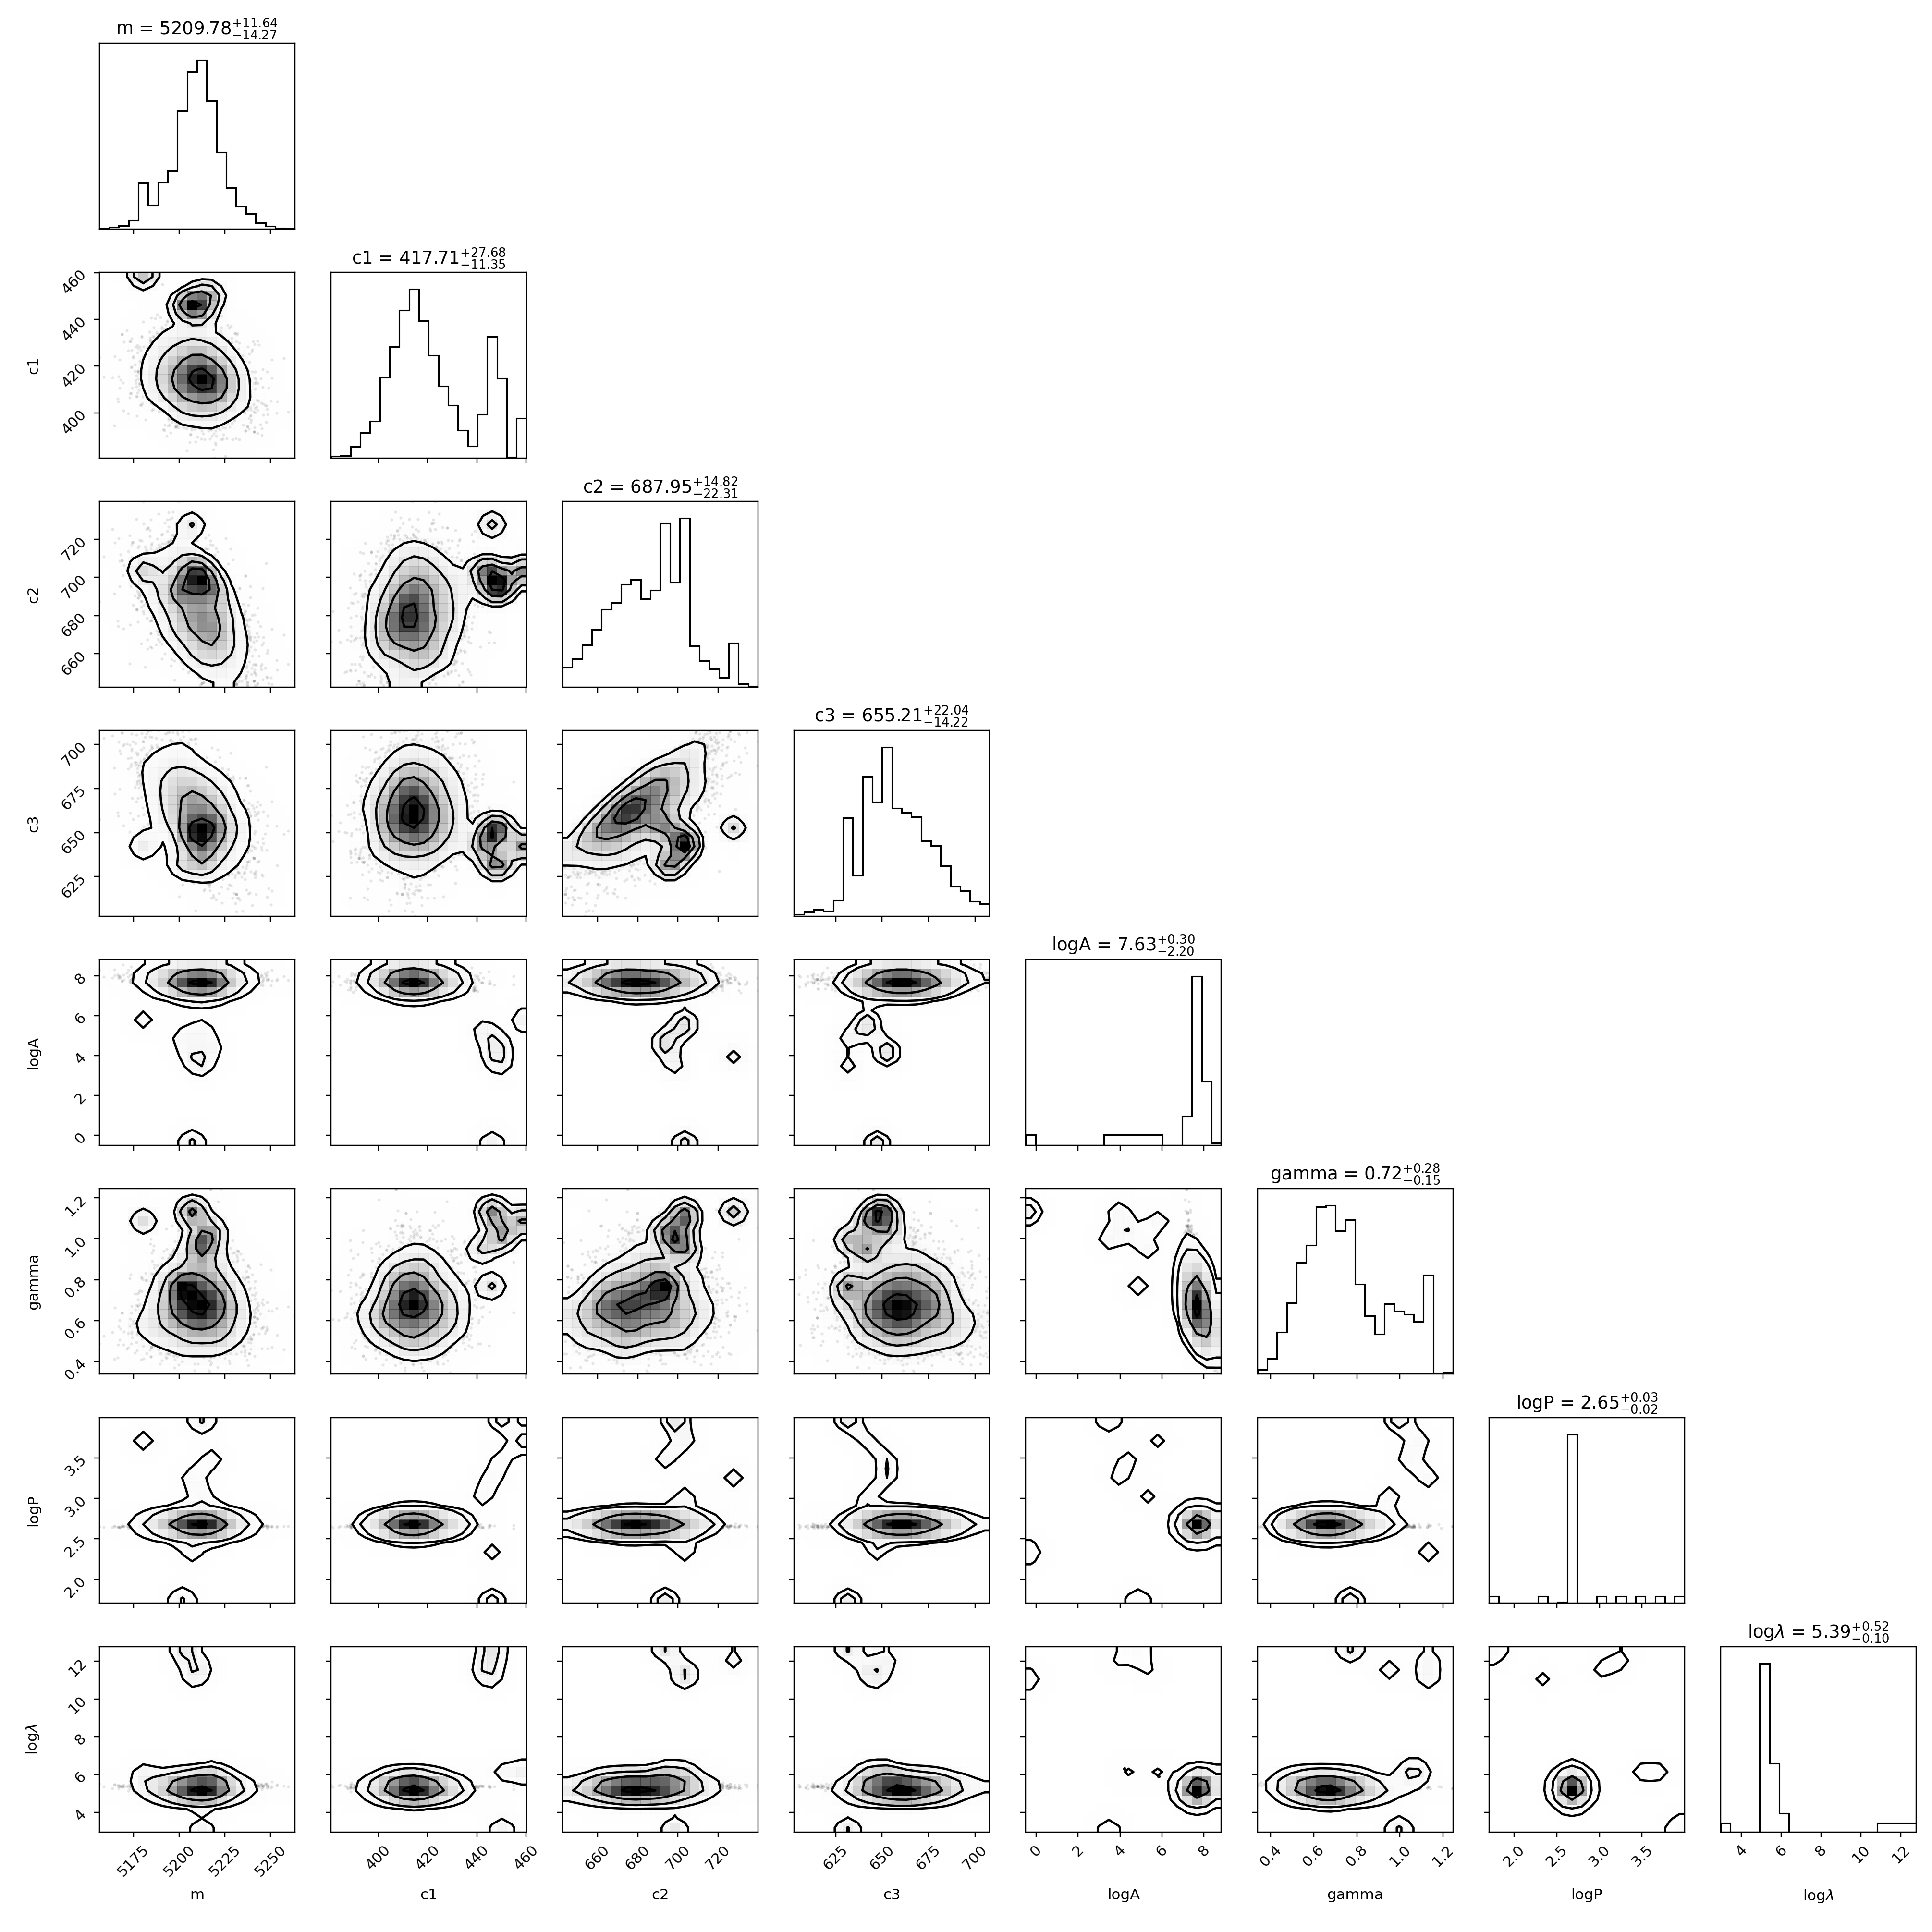

In [13]:
thin = 10
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::thin,:]
import corner
labels = ['m','c1','c2','c3','logA','gamma','logP',r'log$\lambda$']

fig3 = corner.corner(sample,labels=labels, plot_contours=True, show_titles=True, smooth=1)
fig3.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


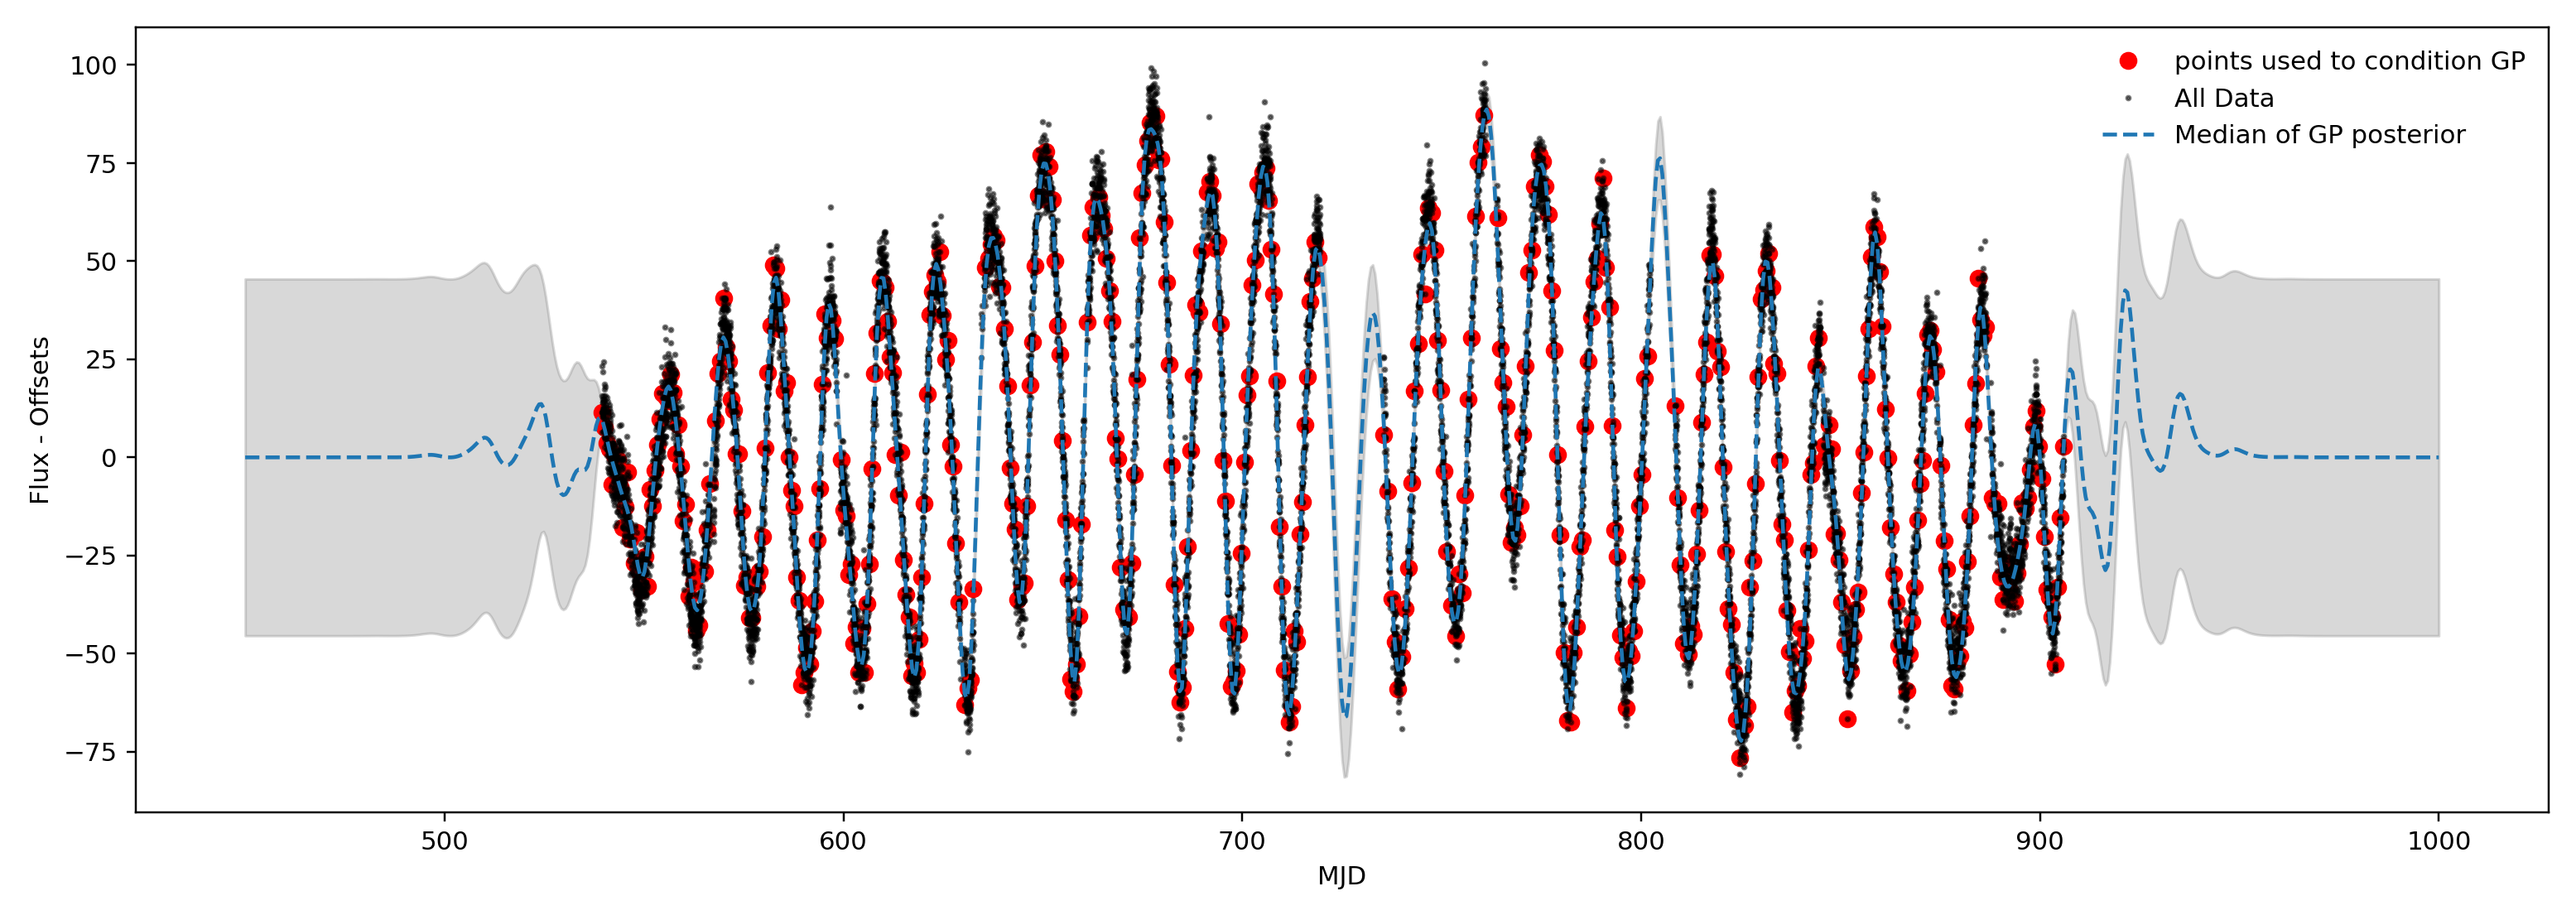

In [14]:
fig4, ax4 = plt.subplots(1,figsize=(14,5))
tgrid = np.linspace(450, 1000, 1001)
stats = np.percentile(sample, [50, 16, 84], axis=0)
res = stats[0]
model.set_parameter_vector(res)

yfull, cov = model.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

tall = tab['time']
yres = y - model.mean.get_value(t)
yall = tab['flux']-model.mean.get_value(tall)
ypred = yfull-model.mean.get_value(tgrid)


ax4.plot(t, yres, 'ro', label='points used to condition GP')
ax4.plot(tall, yall, 'k.', ms=3, alpha=0.5, label='All Data')
ax4.plot(tgrid, ypred, color='C0',linestyle='--', label='Median of GP posterior')
ax4.fill_between(tgrid, ypred-err, ypred+err, color='grey', alpha=0.3)

ax4.set_xlabel('MJD')
ax4.set_ylabel('Flux - Offsets')
ax4.legend(frameon=False)
    
fig4.tight_layout()

### Note that we've only subtracted off constants - the DC flux offsets if you like. 

### The signal on top of those offsets is what is physically interesting and includes the quasi-periodic variations, which the GP has modeled quite admirably - particularly in the gaps between cycles, where there is no data at all. 

### The extrapolation is also believable for a bit  though of course goes to 0 since we specified the mean model as just constants (that are subtracted off here, hence 0).

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [15]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
pred_cols  = ['bestObjID', 'z', 'zErr', 'zphot', 'dzphot']

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [16]:
train = Table.read('cat_train.csv', format='csv')

In [17]:
print(len(train))

413220


In [18]:
def filter_data(data):
    ind = data['zphot_reliable'] == True
    data = data[ind]
    good = np.repeat(True, len(data)) # just a mask variable to store if a row is good or not
    for col in train_cols:
        this_good = ~np.isnan(data[col])
        this_mad  = st.median_abs_deviation(data[col], scale='normal', nan_policy='omit')
        this_ind  = np.abs( data[col] - np.median(data[col]))/this_mad <= 5.
    
        # remember that the cuts for filtering have to be applied together and can't be exclusive
        # i.e. if you decide to cut row 438 because column dered_petro_g is bad, you can't include it 
        # later because column dered_petro_r is fine.
        this_good = np.logical_and(this_good, this_ind) # no nan + within 5x MAD
        good      = np.logical_and(good, this_good)     # cumulative with other cuts
    data = data[good]
    return(data)

In [19]:
train = filter_data(train)
print(len(train))

/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


356346


<IPython.core.display.Javascript object>


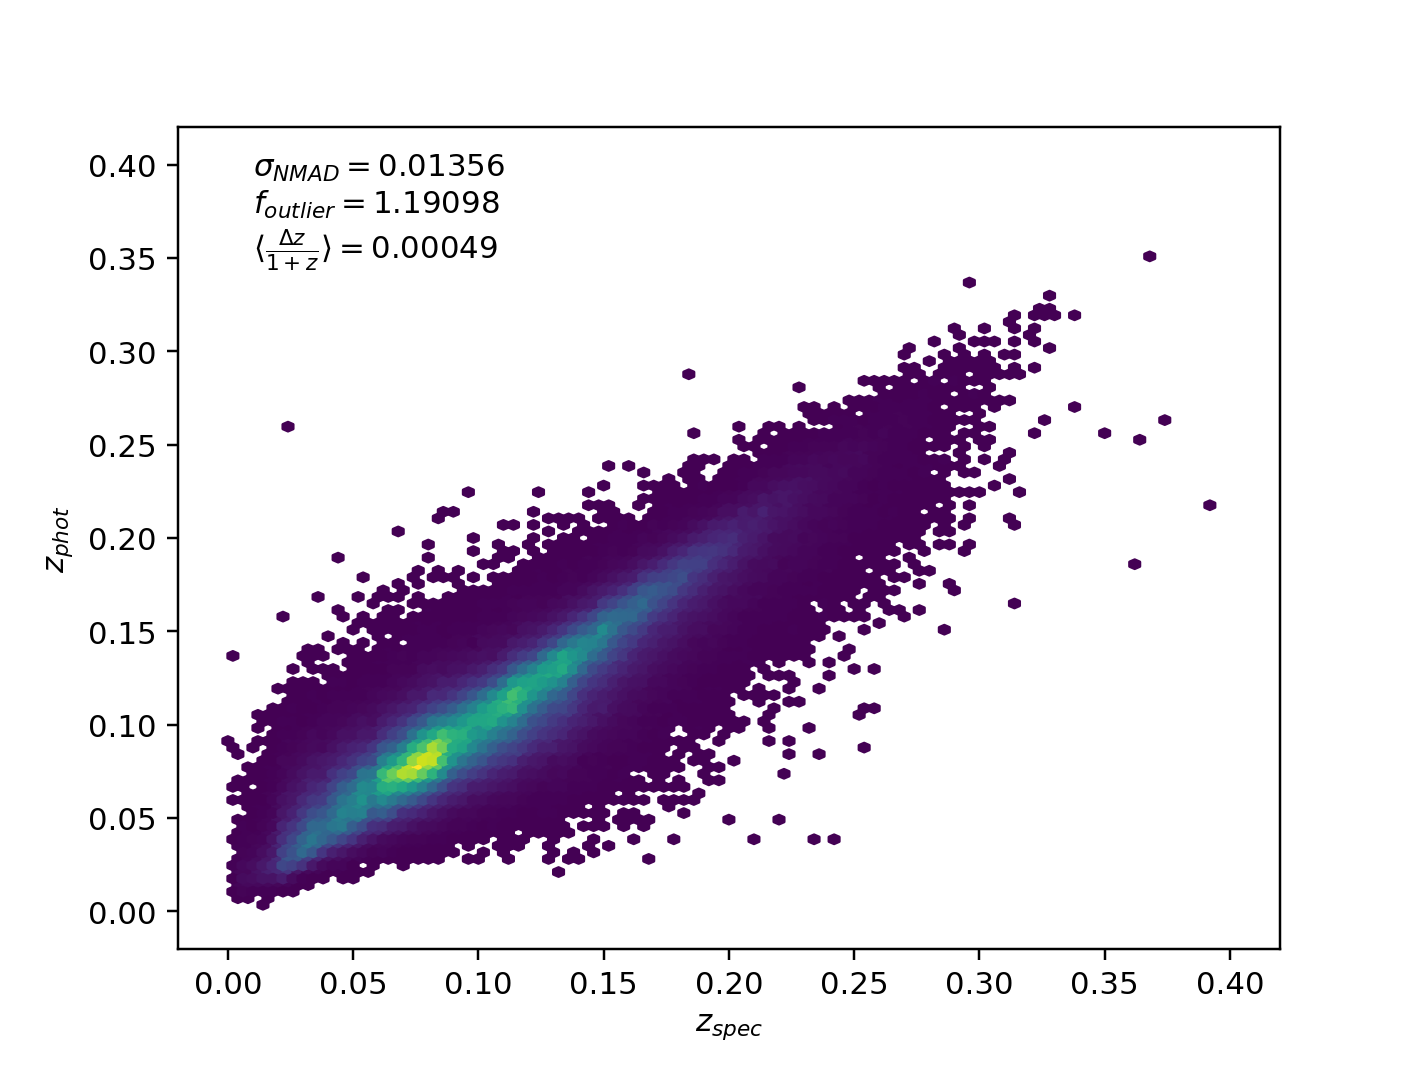

In [20]:
dz1pz = (train['zphot'] - train['z'])/(1. + train['z'])
sig_nmad = st.median_abs_deviation(dz1pz, scale='normal')
f_outlier = len(train[np.abs(dz1pz) > 0.05])/len(train) * 100
pred_bias = np.average(dz1pz) # per the paper, this is the straight average, not weighted by the error

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

label1 = r'$\sigma_{NMAD}  = %.5f$'%sig_nmad
label2 = r'$f_{outlier} = %.5f %%$'%f_outlier
label3 = r'$ \langle \frac{\Delta z}{1+z} \rangle = %.5f $'%pred_bias
label = '\n'.join((label1, label2, label3))

ax.hexbin(train['z'], train['zphot'], mincnt=1, bins=400, extent=[0., 0.4, 0., 0.4])
ax.text(0.01,0.35, label)
ax.set_xlabel('$z_{spec}$')
ax.set_ylabel('$z_{phot}$');


### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

In [21]:
n_trees = [5, 20, 50, 200, 500]


xdata = train[train_cols].as_array().view((float, len(train[train_cols].dtype.names)))
z = train['z'].view(float).data
wz    = 1./train['zErr']**2.
wz = wz.view(float).data

out = {}

for n in n_trees:
    rf = sklearn.ensemble.RandomForestRegressor(n, criterion='squared_error',\
                                       max_features='sqrt', bootstrap=True, n_jobs=-1, oob_score=True,\
                                      random_state=42, verbose=1)
    out[n] = rf.fit(xdata, z, sample_weight=wz)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.8s finished
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.3s finished
[Paralle

<IPython.core.display.Javascript object>


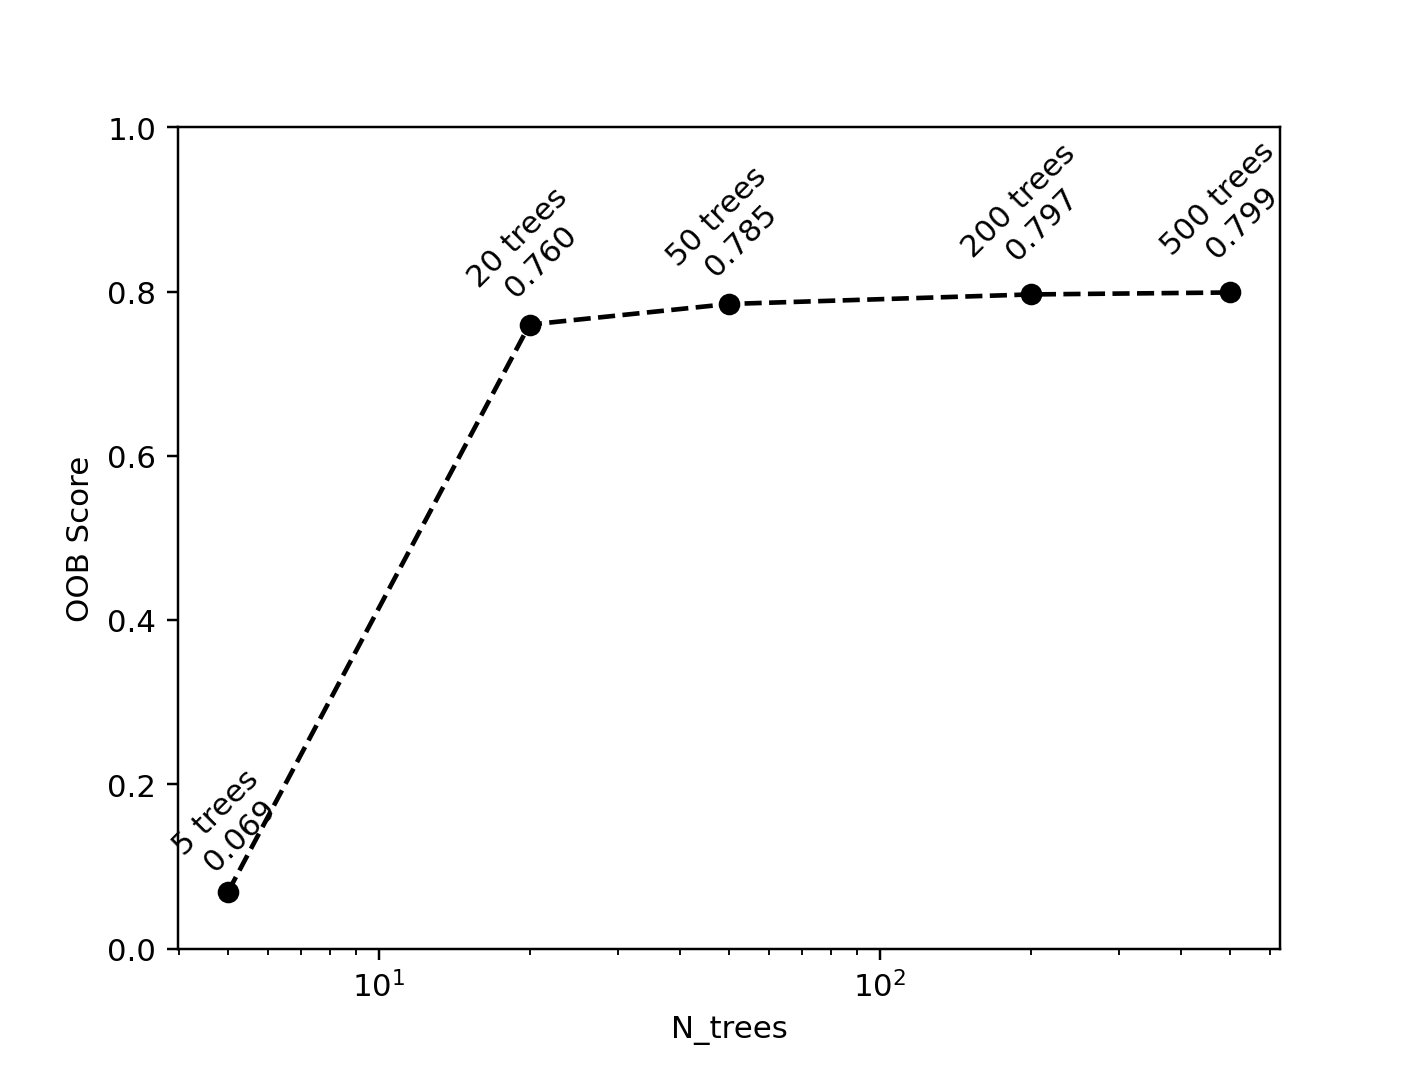

(0.0, 1.0)

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
scores = [out[n].oob_score_ for n in out]
ax.plot(n_trees, scores, 'ko', linestyle='--')
for i, n in enumerate(n_trees):
    ax.text(n, scores[i]+0.01, f'{n} trees\n{scores[i]:.3f}', ha='center', va='bottom', rotation=45)
    
ax.set_xlabel('N_trees')
ax.set_ylabel('OOB Score')
ax.set_xscale('log')
ax.set_ylim(0, 1)

<IPython.core.display.Javascript object>


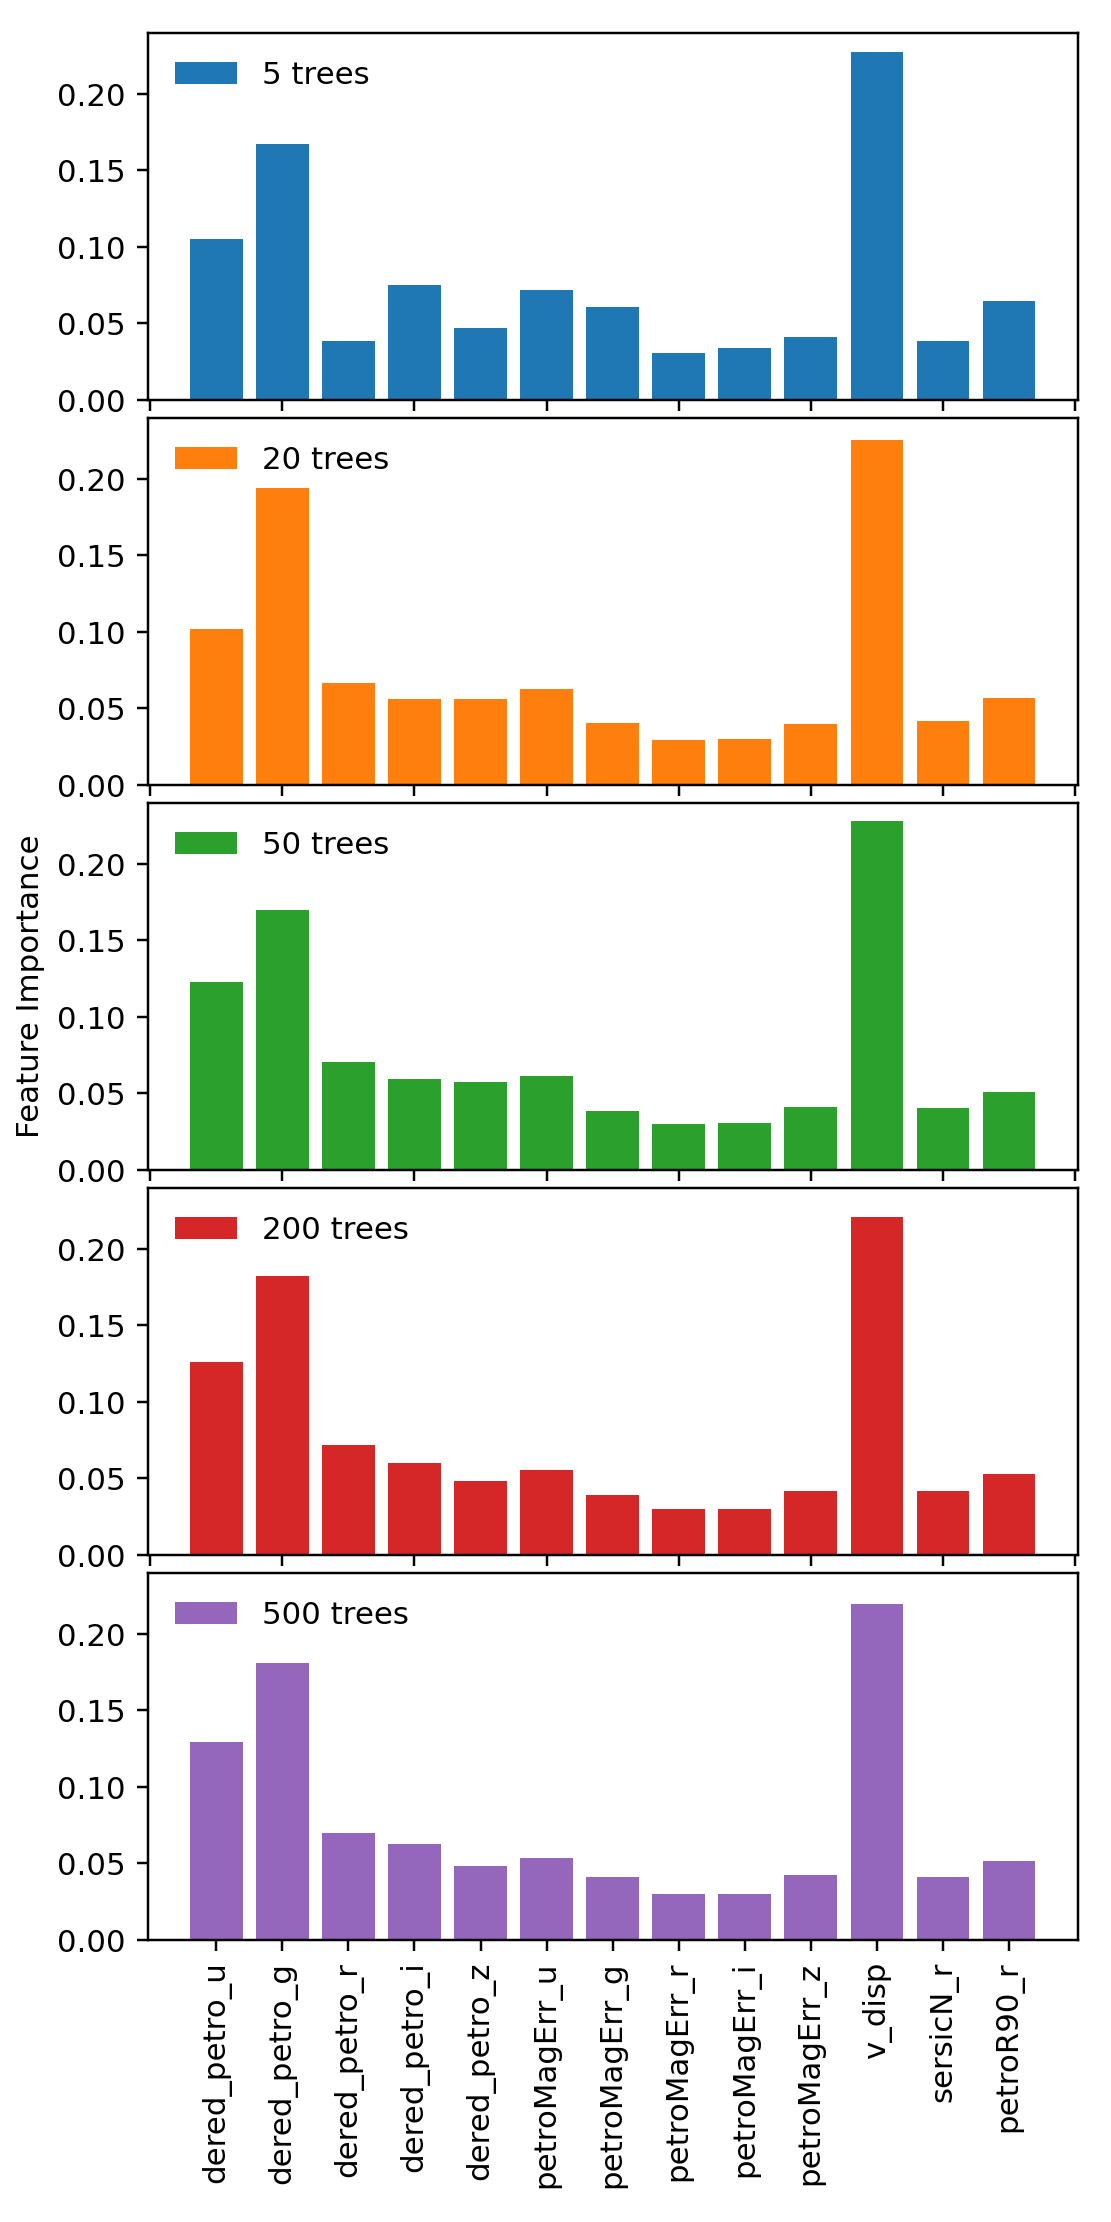

In [23]:
fig = plt.figure(figsize=(5, 10))
feats = np.arange(len(train_cols)) + 1
origax = None
for i, n in enumerate(out):
    
    if origax is None:
        ax = fig.add_subplot(5, 1, i+1)
        origax = ax
    else:
        ax = fig.add_subplot(5, 1, i+1, sharey=origax)
        
    ax.bar(feats, out[n].feature_importances_, label=f'{n} trees', align='center', color=f'C{i}')
    if i != 4:
        ax.set_xticklabels([])
    ax.legend(frameon=False)
    
    if i == 2:
        ax.set_ylabel('Feature Importance')

ax.set_xticks(feats)
ax.set_xticklabels(train_cols, rotation=90)
fig.tight_layout()
plt.subplots_adjust(hspace=0.05)

## The feature importances are quite stable, and make physical sense - it is reasonable that u and g are the velocity dispersion are the most useful properties to predict a redshift. One tells us where the u-band dropout is, and the velocity dispersion says something about the geometry of the galaxy. 

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [24]:
test = Table.read('cat_test.csv', format='csv')

In [25]:
print(len(test))

51652


In [26]:
test = filter_data(test)
print(len(test))

44638


/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [27]:
xpred = test[train_cols].as_array().view((float, len(test[train_cols].dtype.names)))

In [28]:
zpred = out[200].predict(xpred)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   17.1s finished


<IPython.core.display.Javascript object>


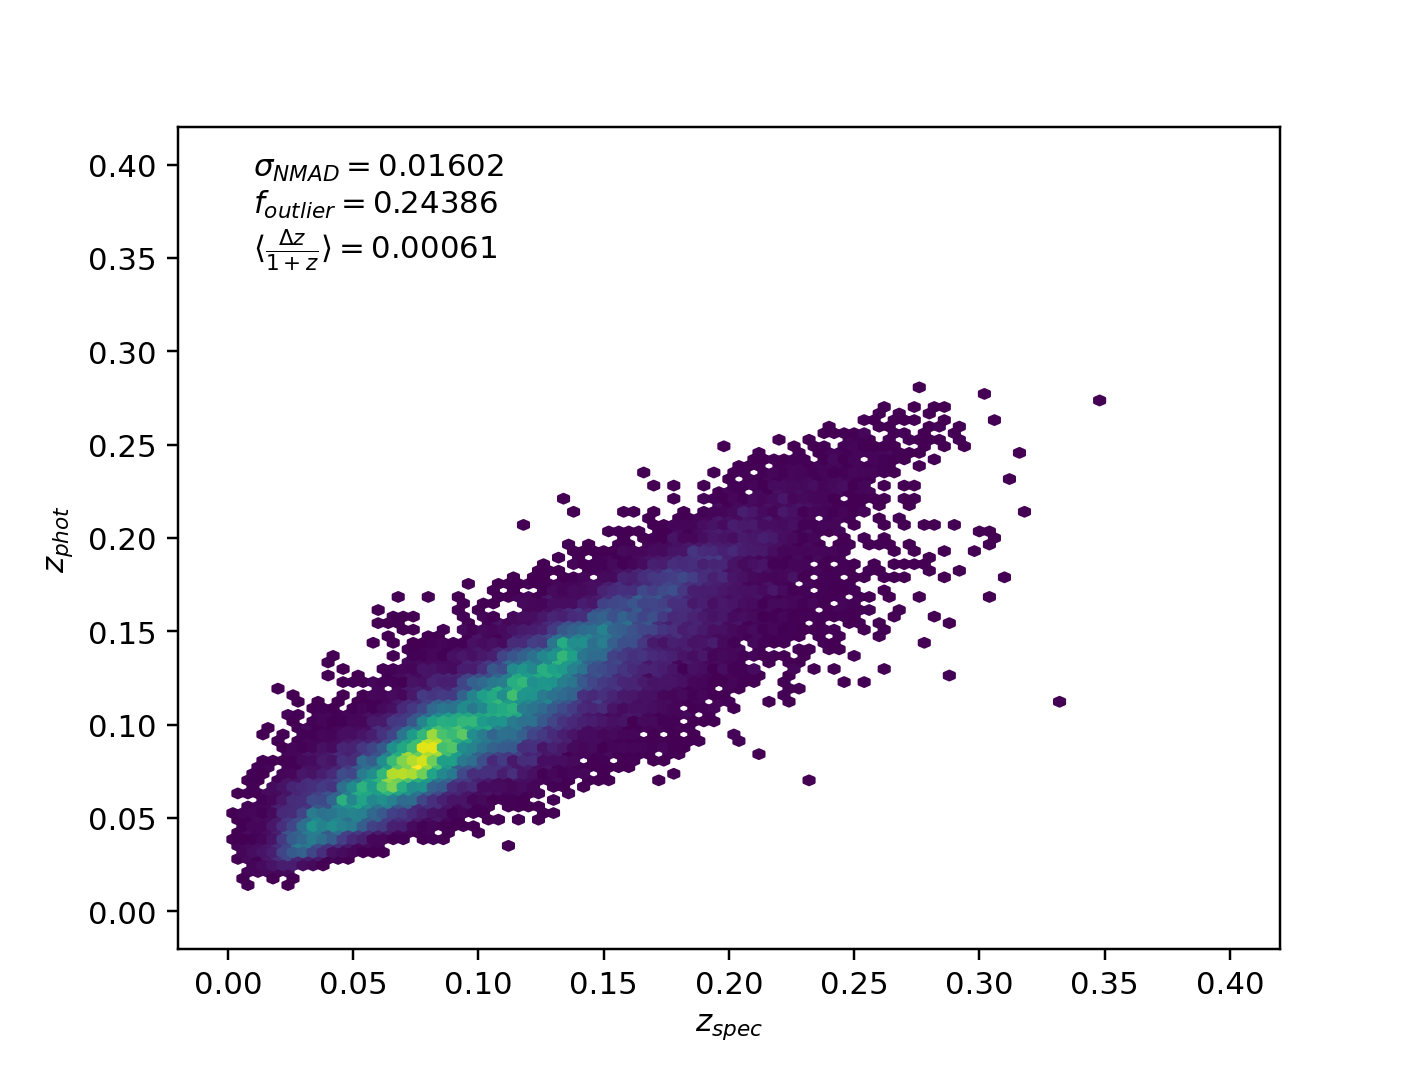

In [29]:
dz1pz = (zpred - test['z'])/(1. + test['z'])
sig_nmad = st.median_abs_deviation(dz1pz, scale='normal')
f_outlier = len(test[np.abs(dz1pz) > 0.05])/len(train) * 100
pred_bias = np.average(dz1pz) # per the paper, this is the straight average, not weighted by the error

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

label1 = r'$\sigma_{NMAD}  = %.5f$'%sig_nmad
label2 = r'$f_{outlier} = %.5f %%$'%f_outlier
label3 = r'$ \langle \frac{\Delta z}{1+z} \rangle = %.5f $'%pred_bias
label = '\n'.join((label1, label2, label3))

ax.hexbin(test['z'], zpred, mincnt=1, bins=400, extent=[0., 0.4, 0., 0.4])
ax.text(0.01,0.35, label)
ax.set_xlabel('$z_{spec}$')
ax.set_ylabel('$z_{phot}$');

<IPython.core.display.Javascript object>


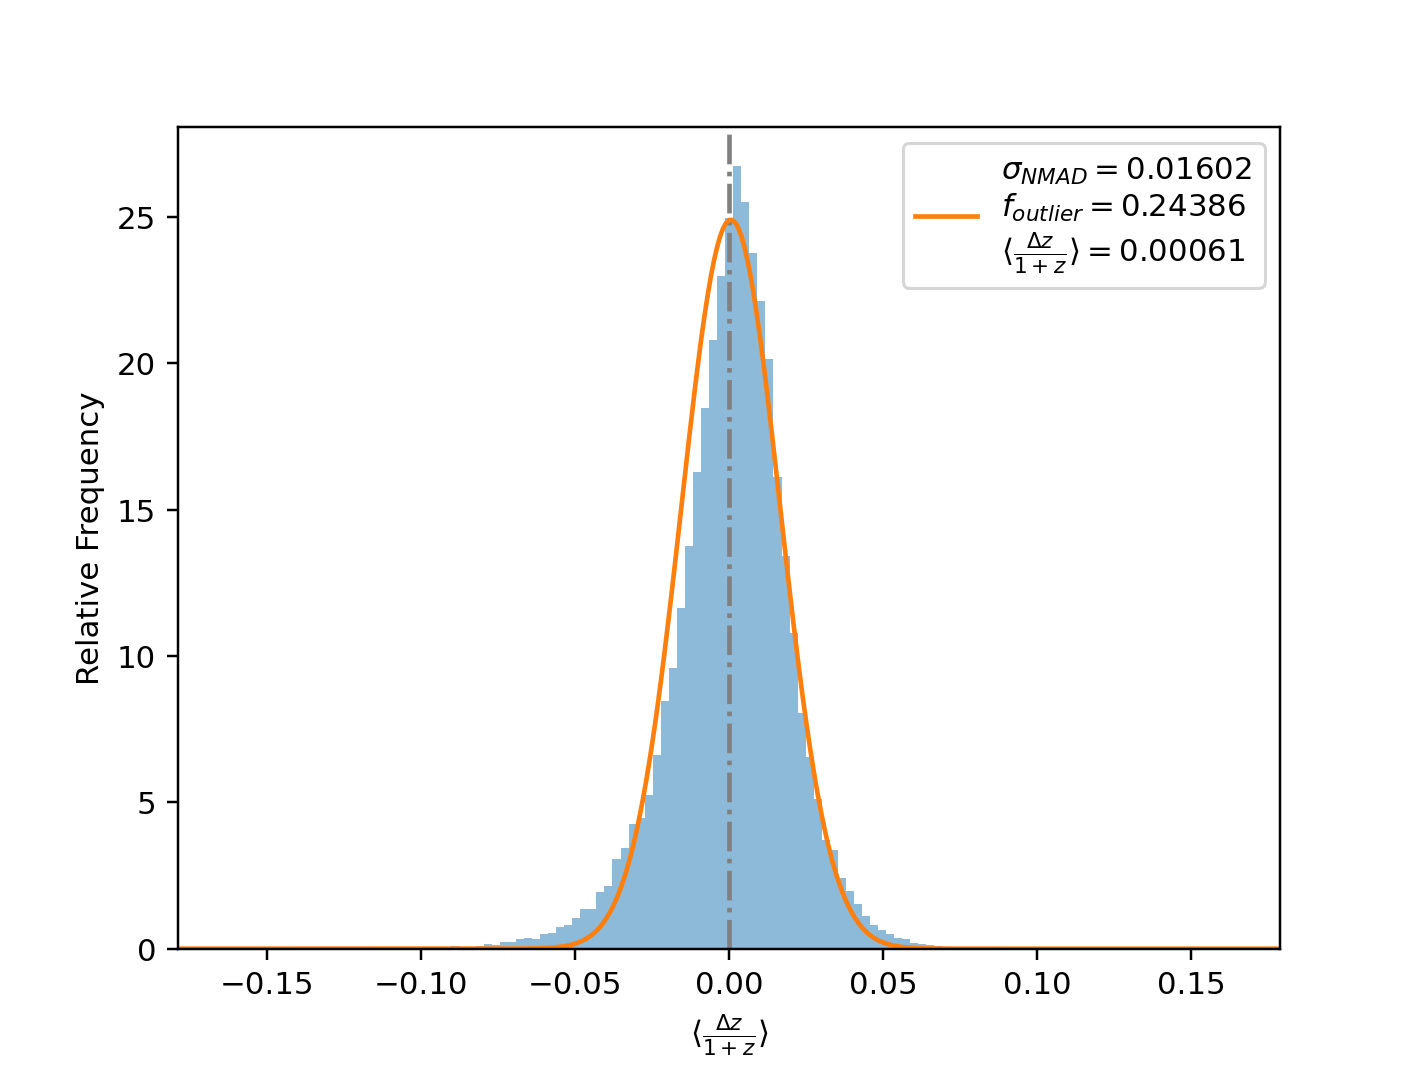

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(dz1pz, density=True, bins=100, alpha=0.5)
ax.axvline(0., color='grey', linestyle='-.')
xmin, xmax = ax.get_xlim()
xext = np.max([np.abs(xmin), np.abs(xmax)])
ax.set_xlim(-xext, xext)
xr = np.arange(-xext, xext + 0.001, 0.001)
xg = st.norm.pdf(xr, pred_bias, sig_nmad)
ax.plot(xr, xg, color='C1', linestyle='-', label=label)
ax.legend()
ax.set_xlabel(r'$ \langle \frac{\Delta z}{1+z} \rangle $')
ax.set_ylabel('Relative Frequency');
